# Fixed fraud detection pipeline
This notebook loads `historical.csv`, creates a stratified train-test split, builds resampling pipelines (SMOTE, SMOTE+Tomek, ADASYN, ADASYN+Tomek) each with a RandomForest classifier, fits them, evaluates on the test set, and compares metrics (precision, recall, f1, and FCR = (FP+FN)/N).

In [16]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt

# For reproducibility
RANDOM_STATE = 42


In [17]:
# Load data
data = pd.read_csv('historical.csv')
print('shape:', data.shape)
print('columns:', data.columns.tolist())
data.head()

shape: (185124, 31)
columns: ['tid', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'outcome']


,tid,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,49b18cea-beb8-413d-b268-a0ec12a4147c,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0d1de000-6756-4441-8133-e0ed75b72979,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,dc548f8c-ecd2-4fee-8a80-f2de7e2c7bd6,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,f105abf5-0c4c-4e79-9a8a-59de254e58dc,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,164a2881-40c6-43ba-b53e-cd1e5a9e8cee,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0


In [18]:
# Prepare features and target
# Assumes the dataset has columns 'tid' and 'outcome' like in your original notebook.
# If your target column has a different name, update `target_col` below.
target_col = 'outcome'
id_col = 'tid' if 'tid' in data.columns else None

if target_col not in data.columns:
    raise ValueError(f"Target column '{target_col}' not found in the dataframe. Available columns: {data.columns.tolist()}")

X = data.drop(columns=[target_col] + ([id_col] if id_col is not None else []))
y = data[target_col]

# If there's an 'Amount' column used in evaluation, ensure it's kept in a copy for later
amounts = X['Amount'].copy() if 'Amount' in X.columns else None

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Positive ratio (train):', y_train.mean(), 'Positive ratio (test):', y_test.mean())

Train shape: (148099, 29) Test shape: (37025, 29)
Positive ratio (train): 0.0017285734542434453 Positive ratio (test): 0.0017285617825793383


In [19]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 39

# -------------------------------
# Same RandomForest everywhere
# -------------------------------
rf_base = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

pipelines = {
    "rf_only": Pipeline([
        ("rf", rf_base)
    ]),

    # === From search results ===
    "undersampling": Pipeline([
        ("under", RandomUnderSampler(
            sampling_strategy=0.3,
            random_state=RANDOM_STATE
        )),
        ("rf", rf_base)
    ]),

    "oversampling": Pipeline([
        ("over", RandomOverSampler(
            sampling_strategy=1.0,
            random_state=RANDOM_STATE
        )),
        ("rf", rf_base)
    ]),

    "tomek": Pipeline([
        ("tomek", TomekLinks()),
        ("rf", rf_base)
    ]),

    "smote": Pipeline([
        ("smote", SMOTE(
            sampling_strategy=1.0,
            k_neighbors=5,
            random_state=RANDOM_STATE
        )),
        ("rf", rf_base)
    ]),

    "smote_tomek": Pipeline([
        ("smote", SMOTE(
            sampling_strategy=1.0,
            k_neighbors=5,
            random_state=RANDOM_STATE
        )),
        ("tomek", TomekLinks()),
        ("rf", rf_base)
    ]),

    "adasyn": Pipeline([
        ("adasyn", ADASYN(
            sampling_strategy=1.0,
            n_neighbors=5,
            random_state=RANDOM_STATE
        )),
        ("rf", rf_base)
    ]),

    "adasyn_tomek": Pipeline([
        ("adasyn", ADASYN(
            sampling_strategy=1.0,
            n_neighbors=5,
            random_state=RANDOM_STATE
        )),
        ("tomek", TomekLinks()),
        ("rf", rf_base)
    ]),

    "class_weight_balanced": Pipeline([
        ("rf", RandomForestClassifier(
            n_estimators=500,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),

    "class_weight_manual": Pipeline([
        ("rf", RandomForestClassifier(
            n_estimators=500,
            class_weight={0: 1, 1: 10},
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])
}

print("✅ Pipelines defined with best params:", list(pipelines.keys()))


✅ Pipelines defined with best params: ['rf_only', 'undersampling', 'oversampling', 'tomek', 'smote', 'smote_tomek', 'adasyn', 'adasyn_tomek', 'class_weight_balanced', 'class_weight_manual']


In [20]:
# Fit all pipelines on training data
fitted_pipelines = {}
for name, pipe in pipelines.items():
    try:
        print('Fitting', name)
        pipe.fit(X_train, y_train)
        fitted_pipelines[name] = pipe
    except Exception as e:
        print('Error fitting', name, e)

len(fitted_pipelines), list(fitted_pipelines.keys())

Fitting rf_only
Fitting undersampling
Fitting oversampling
Fitting tomek
Fitting smote
Fitting smote_tomek
Fitting adasyn
Fitting adasyn_tomek
Fitting class_weight_balanced
Fitting class_weight_manual


(10,
 ['rf_only',
  'undersampling',
  'oversampling',
  'tomek',
  'smote',
  'smote_tomek',
  'adasyn',
  'adasyn_tomek',
  'class_weight_balanced',
  'class_weight_manual'])

In [21]:
# Evaluate all fitted pipelines
results = []

# Make sure to use the same transaction amounts from X_test
amounts_test = X_test["Amount"] if "Amount" in X_test.columns else None

for name, pipe in fitted_pipelines.items():
    print(f"Evaluating {name}...")
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    metrics = evaluate_fraud_model(
        y_true=y_test,
        y_pred=y_pred,
        y_proba=y_proba,
        transaction_amounts=amounts_test
    )
    metrics["Model"] = name
    results.append(metrics)

# Create results DataFrame
results_df = pd.DataFrame(results)
display(results_df)


Evaluating rf_only...
Evaluating undersampling...
Evaluating oversampling...
Evaluating tomek...
Evaluating smote...
Evaluating smote_tomek...
Evaluating adasyn...
Evaluating adasyn_tomek...
Evaluating class_weight_balanced...
Evaluating class_weight_manual...


,precision,recall,f1,specificity,pr_auc,fraud_capture_rate,net_savings,tn,fp,fn,tp,Model
0,0.901961,0.718750,0.800000,0.999865,0.809353,71.8750,343.79,36956,5,18,46,rf_only
1,0.901961,0.718750,0.800000,0.999865,0.809353,71.8750,343.79,36956,5,18,46,undersampling
2,0.901961,0.718750,0.800000,0.999865,0.809353,71.8750,343.79,36956,5,18,46,oversampling
3,0.901961,0.718750,0.800000,0.999865,0.809353,71.8750,343.79,36956,5,18,46,tomek
4,0.901961,0.718750,0.800000,0.999865,0.809353,71.8750,343.79,36956,5,18,46,smote
5,0.901961,0.718750,0.800000,0.999865,0.809353,71.8750,343.79,36956,5,18,46,smote_tomek
6,0.901961,0.718750,0.800000,0.999865,0.809353,71.8750,343.79,36956,5,18,46,adasyn
7,0.901961,0.718750,0.800000,0.999865,0.809353,71.8750,343.79,36956,5,18,46,adasyn_tomek
8,0.976190,0.640625,0.773585,0.999973,0.819939,64.0625,-197.25,36960,1,23,41,class_weight_balanced
9,0.977778,0.687500,0.807339,0.999973,0.802373,68.7500,314.07,36960,1,20,44,class_weight_manual


In [14]:
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, average_precision_score
)

# -------------------------------
# Unified Fraud Evaluation
# -------------------------------
def evaluate_fraud_model(y_true, y_pred, y_proba, transaction_amounts, cost_fp=1, cost_fn_factor=1.0):
    """
    Evaluate fraud detection model performance with ML and business metrics.
    
    Parameters
    ----------
    y_true : array-like
        True labels (1 = fraud, 0 = normal).
    y_pred : array-like
        Predicted labels (1 = fraud, 0 = normal).
    y_proba : array-like
        Predicted probabilities for fraud class (for PR-AUC).
    transaction_amounts : array-like
        Dollar amount of each transaction.
    cost_fp : float
        Cost of investigating a false positive.
    cost_fn_factor : float
        Multiplier for fraud cost if missed (1.0 = full loss).
        
    Returns
    -------
    dict
        Metrics including precision, recall, f1, specificity, PR-AUC,
        fraud capture rate, net savings, and confusion matrix counts.
    """
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Classification metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Probability-based metric
    pr_auc = average_precision_score(y_true, y_proba)

    # Business metrics
    fraud_capture_rate = recall  # recall is capture rate
    savings_detected = transaction_amounts[(y_true == 1) & (y_pred == 1)].sum()
    losses_missed = transaction_amounts[(y_true == 1) & (y_pred == 0)].sum() * cost_fn_factor
    investigation_costs = fp * cost_fp
    net_savings = savings_detected - losses_missed - investigation_costs

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity,
        "pr_auc": pr_auc,
        "fraud_capture_rate": fraud_capture_rate * 100,
        "net_savings": net_savings,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }

def compare_models(y_true, transaction_amounts, **model_outputs):
    """
    Compare multiple models using unified fraud metrics.
    
    model_outputs = { "model_name": (y_pred, y_proba), ... }
    """
    results = []
    for model_name, (y_pred, y_proba) in model_outputs.items():
        metrics = evaluate_fraud_model(y_true, y_pred, y_proba, transaction_amounts)
        metrics["model"] = model_name
        results.append(metrics)
    return pd.DataFrame(results).set_index("model").sort_values(by="fraud_capture_rate", ascending=False)


# -------------------------------
# Run evaluation on fitted pipelines
# -------------------------------
predictions = {}
for name, pipe in fitted_pipelines.items():
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]  # probability of fraud
    predictions[name] = (y_pred, y_proba)

results_df = compare_models(
    y_true=y_test,
    transaction_amounts=X_test["Amount"],
    **predictions
)

print(results_df)


                       precision    recall        f1  specificity    pr_auc  \
model                                                                         
rf_only                 0.901961  0.718750  0.800000     0.999865  0.809353   
undersampling           0.901961  0.718750  0.800000     0.999865  0.809353   
oversampling            0.901961  0.718750  0.800000     0.999865  0.809353   
tomek                   0.901961  0.718750  0.800000     0.999865  0.809353   
smote                   0.901961  0.718750  0.800000     0.999865  0.809353   
smote_tomek             0.901961  0.718750  0.800000     0.999865  0.809353   
adasyn                  0.901961  0.718750  0.800000     0.999865  0.809353   
adasyn_tomek            0.901961  0.718750  0.800000     0.999865  0.809353   
class_weight_manual     0.977778  0.687500  0.807339     0.999973  0.802373   
class_weight_balanced   0.976190  0.640625  0.773585     0.999973  0.819939   

                       fraud_capture_rate  net_savi

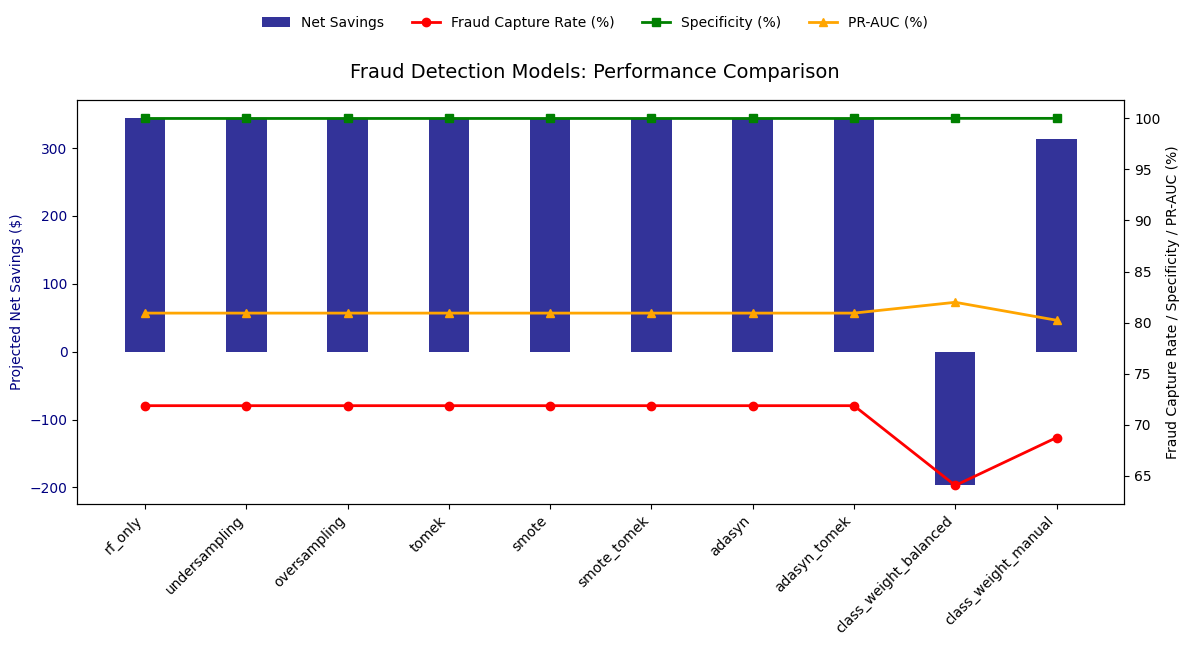

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# --- Explicit x positions with spacing ---
x = np.arange(len(results_df["Model"])) * 1.5   # 1.5 spacing instead of 1
bar_width = 0.6

# --- Bar chart for Net Savings ---
ax1.bar(x, results_df["Net Savings ($)"],
        width=bar_width, color="navy", alpha=0.8, label="Net Savings")
ax1.set_ylabel("Projected Net Savings ($)", color="navy")
ax1.tick_params(axis="y", labelcolor="navy")

# Replace tick labels with model names
ax1.set_xticks(x)
ax1.set_xticklabels(results_df["Model"], rotation=45, ha="right")

# --- Secondary axis for Fraud Capture Rate, Specificity, PR-AUC ---
ax2 = ax1.twinx()

ax2.plot(x, results_df["Fraud Capture Rate (%)"],
         color="red", marker="o", linewidth=2, label="Fraud Capture Rate (%)")

ax2.plot(x, results_df["Specificity"]*100,
         color="green", marker="s", linewidth=2, label="Specificity (%)")

ax2.plot(x, results_df["PR-AUC"]*100,
         color="orange", marker="^", linewidth=2, label="PR-AUC (%)")

ax2.set_ylabel("Fraud Capture Rate / Specificity / PR-AUC (%)")
ax2.tick_params(axis="y")

# --- Title & Legend ---
fig.suptitle("Fraud Detection Models: Performance Comparison", fontsize=14)
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.08),
           ncol=4, frameon=False)

fig.tight_layout()
plt.show()


# DONT MIND THIS MIGS


In [4]:
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, recall_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline

# --------------------
# 1. Load data
# --------------------
df = pd.read_csv("historical.csv")
X = df.drop(columns=["tid", "outcome"])
y = df["outcome"]

# --------------------
# 2. Base model
# --------------------
RANDOM_STATE = 39
rf_base = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# --------------------
# 3. CV + Scorer
# --------------------
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(recall_score)

# --------------------
# 4. Define search spaces
# --------------------
search_spaces = {
    "undersampling": (
        ImbPipeline([("sampler", RandomUnderSampler(random_state=RANDOM_STATE)),
                     ("clf", rf_base)]),
        {"sampler__sampling_strategy": [0.1, 0.3]}
    ),
    "oversampling": (
        ImbPipeline([("sampler", RandomOverSampler(random_state=RANDOM_STATE)),
                     ("clf", rf_base)]),
        {"sampler__sampling_strategy": [0.5, 1.0]}
    ),
    "tomek": (
        ImbPipeline([("sampler", TomekLinks()),
                     ("clf", rf_base)]),
        {}  # no tunable params
    ),
    "smote": (
        ImbPipeline([("sampler", SMOTE(random_state=RANDOM_STATE)),
                     ("clf", rf_base)]),
        {"sampler__k_neighbors": [3, 5]}
    ),
    "smote_tomek": (
        ImbPipeline([("smote", SMOTE(random_state=RANDOM_STATE)),
                     ("tomek", TomekLinks()),
                     ("clf", rf_base)]),
        {"smote__k_neighbors": [3, 5]}
    ),
    "adasyn": (
        ImbPipeline([("sampler", ADASYN(random_state=RANDOM_STATE)),
                     ("clf", rf_base)]),
        {"sampler__n_neighbors": [3, 5]}
    ),
    "adasyn_tomek": (
        ImbPipeline([("adasyn", ADASYN(random_state=RANDOM_STATE)),
                     ("tomek", TomekLinks()),
                     ("clf", rf_base)]),
        {"adasyn__n_neighbors": [3, 5]}
    ),
    "class_weight_balanced": (
        Pipeline([("clf", rf_base)]),
        {"clf__class_weight": ["balanced"]}
    ),
    "class_weight_manual": (
        Pipeline([("clf", rf_base)]),
        {"clf__class_weight": [{0: 1, 1: w} for w in [5, 10, 20]]}
    ),
}

# --------------------
# 5. Run searches
# --------------------
best_params = {}

for name, (pipe, param_grid) in search_spaces.items():
    print(f"\n🔍 Running search for: {name}")
    start = time.time()
    
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=5,             # short search
        cv=cv,
        scoring=scorer,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE
    )
    
    search.fit(X, y)
    elapsed = time.time() - start
    
    print(f"⏱ {name} finished in {elapsed:.1f} sec")
    print(f"✅ Best recall: {search.best_score_:.4f}")
    print(f"✅ Best params: {search.best_params_}")
    
    best_params[name] = {
        "best_params": search.best_params_,
        "best_recall": search.best_score_
    }

# --------------------
# 6. Print summary
# --------------------
print("\n=== Summary of Best Results ===")
for method, result in best_params.items():
    print(f"{method}: recall={result['best_recall']:.4f}, params={result['best_params']}")



🔍 Running search for: undersampling
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\d3lus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


⏱ undersampling finished in 6.2 sec
✅ Best recall: 0.8469
✅ Best params: {'sampler__sampling_strategy': 0.3}

🔍 Running search for: oversampling
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\d3lus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


⏱ oversampling finished in 204.4 sec
✅ Best recall: 0.7531
✅ Best params: {'sampler__sampling_strategy': 1.0}

🔍 Running search for: tomek
Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\d3lus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


⏱ tomek finished in 227.1 sec
✅ Best recall: 0.7469
✅ Best params: {}

🔍 Running search for: smote
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\d3lus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


⏱ smote finished in 429.0 sec
✅ Best recall: 0.7906
✅ Best params: {'sampler__k_neighbors': 5}

🔍 Running search for: smote_tomek
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\d3lus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


⏱ smote_tomek finished in 706.1 sec
✅ Best recall: 0.7937
✅ Best params: {'smote__k_neighbors': 5}

🔍 Running search for: adasyn
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\d3lus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


⏱ adasyn finished in 426.4 sec
✅ Best recall: 0.7812
✅ Best params: {'sampler__n_neighbors': 5}

🔍 Running search for: adasyn_tomek
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\d3lus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


⏱ adasyn_tomek finished in 676.1 sec
✅ Best recall: 0.7812
✅ Best params: {'adasyn__n_neighbors': 5}

🔍 Running search for: class_weight_balanced
Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\d3lus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


⏱ class_weight_balanced finished in 85.4 sec
✅ Best recall: 0.7219
✅ Best params: {'clf__class_weight': 'balanced'}

🔍 Running search for: class_weight_manual
Fitting 2 folds for each of 3 candidates, totalling 6 fits


c:\Users\d3lus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


⏱ class_weight_manual finished in 323.1 sec
✅ Best recall: 0.7438
✅ Best params: {'clf__class_weight': {0: 1, 1: 10}}

=== Summary of Best Results ===
undersampling: recall=0.8469, params={'sampler__sampling_strategy': 0.3}
oversampling: recall=0.7531, params={'sampler__sampling_strategy': 1.0}
tomek: recall=0.7469, params={}
smote: recall=0.7906, params={'sampler__k_neighbors': 5}
smote_tomek: recall=0.7937, params={'smote__k_neighbors': 5}
adasyn: recall=0.7812, params={'sampler__n_neighbors': 5}
adasyn_tomek: recall=0.7812, params={'adasyn__n_neighbors': 5}
class_weight_balanced: recall=0.7219, params={'clf__class_weight': 'balanced'}
class_weight_manual: recall=0.7438, params={'clf__class_weight': {0: 1, 1: 10}}
